#  CM50265 Machine Learning 2

## Coursework 2: Deep learning
### Youssef Alami Mejjati, Jordan Taylor, Jake Deane and Mohammad Golbabaee


This coursework is worth 75 points from the overall mark of 100 for this unit. Marks are given beside each task. The report will be your main method of assessment. __Students should form groups of 3 individuals and submit one report per group.__ For this coursework students can choose their partners until __20th February__.  Each group will receive a total mark for this course work and individuals in that group will share this mark (with weights) according to their contributions.  

- The __submission deadline__ for your report is
__17th May 2020, 12:00: online Moodle submission of your final report__

The main part of your report should not exceed __3000 word limit__. After the main part please attach a Table of individuals’ contributions and appendices including ONLY the codes (these are excluded from the word limit). The report should be submitted in PDF format. __Table of contributions__ should include both students’ names/university IDs, the list of contributions of each student, and finally the contribution percentage for each student. This percentage should be agreed between both individuals and it will be used to weigh their marks. We highly encourage individuals to evenly share the workload. Further, you should __include all codes__ relevant to your implementations as an appendix or appendices with a clear referencing to the main body of your report. Codes must be well commented (indicating major steps).

First and foremost your report should demonstrate and evaluate your results. It must include figures and screenshots with appropriate resolutions. Evaluation can be qualitative (how it looks) and, wherever possible, quantitative (tested numerically). Second you should provide evidence that you understood the mathematics behind the assignment in each task/question. You should concisely explain your approach to solve each task/question, and the choices you make (e.g. hyper-parameters etc) for each part.

Usual university rules apply, please check your MSc program handbook, particularly regarding plagiarism and delayed deliveries. 

__Note:__ All tasks should be implemented in TensorFlow. Guidelines below (tasks 3-5, 7) should work for a TensorFlow version 1. If you use TF v2 please note that some syntaxes have changed during the recent update, but you can still use version compatiblity to resolve the issue. The list includes but might not be limited to:

tf.layers.conv2d -> tf.nn.conv2d

tf.layers.dense -> tf.nn.dense

tf.layers.flatten -> tf.compat.v1.layers.flatten

tf.variable_scope -> tf.compat.v1.variable_scope

tf.get_collection -> tf.compat.v1.get_collection

similarly for tf.compat.v1.InteractiveSession, tf.compat.v1.train.AdamOptimizer, tf.compat.v1.placeholder, tf.compat.v1.global_variables_initializer, tf.compat.v1.local_variables_initializer, tf.compat.v1.train.Saver, tf.compat.v1.summary.FileWriter, tf.compat.v1.trainable_variables

See TF web documentation in case you encounter version incompatibility. 

Guides on tasks 6 and 8 should be already compatible with TF2. 


## The coursework 


In [1]:
import warnings
import time
warnings.filterwarnings('ignore')
import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
#use import tensorflow.compat.v1 as tf for tensorflow 1
# tf.disable_v2_behaviour() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib inline



In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [3]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [4]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

print(x_train.shape)
print(x_train)
m = np.amax(x_train)
print(m)
print(y_train)

ymax = np.amax(y_train)
ymin = np.amin(y_train)

print(ymax)
print(ymin)

(60000, 784)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]
1.0
[5 0 4 ... 5 6 8]
9
0


### 1. Data visualisation (5 points)
Project the training data points in a 2D space using PCA. Use the obtained 2D embedding and plot the training data-points with different markers or colors for each class (you are allowed to use PCA from scikit learn). 
- Why PCA is a good option to visualize data? 
- Add this plot in your report and discuss your observations. 
- Which classes can be linearly separated?


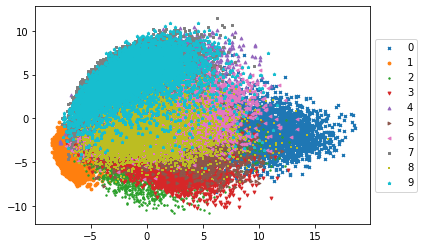

In [5]:
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x_train)

markers = ['x','o','.','v','^','>','<','s','+','*']

for i in range(0,10):
    
    plt.scatter(x_reduced[y_train==i][:,0], x_reduced[y_train==i][:,1], label=str(i), marker=markers[i], s=8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 2. Perceptrons: (10 points)
Single Layer Perceptron is one of the most basic binary classifiers one can use. In this part of the CW you should implement an iterative algorithm for training the Single Layer Perceptron.

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In addition we choose our binary labels to be -1 and 1, respectively.

In [5]:
cond = (y_train == 0) + (y_train == 1)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.

cond = (y_test == 0) + (y_test == 1)
binary_x_test = x_test[cond,:]
binary_y_test = y_test[cond]*1.


In [6]:
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1

binary_y_test[binary_y_test == 0] = -1
binary_y_test[binary_y_test == 1] = 1

#### Task 2.1
Complete the function 'predict' below.
#### inputs:

+ $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
+ $w \in\mathbb{R^m}$ is the parameter vector we wish to learn. 
+ $b \in\mathbb{R}$ is the corresponding bias.

#### outputs: 
+ 'prediction'$\in\mathbb{R^n}$, a vector containing prediction values associated with $x$. 

In [7]:
def predict(x, w, b):
    ######### Complete the function- x point ######### 
    #x = np.transpose(x)
    mmult = np.dot(w,x)
    prediction = np.sign(mmult + b)

    ######################################
    return prediction

#### Task 2.2
+ Use the funtion 'predict' above to implement the Single Layer Perceptron algorithm by completing the function 'optimize' defined below.
    #### inputs:

    + $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
    + $w \in\mathbb{R^m}$ is the initial parameter vector.
    + $b \in\mathbb{R}$ is the initial bias value.
    + $y\in\mathbb{R^n}$ is the training labels associated with x.
    #### outputs:
    + $w$ is the optimized parameter vector.
    + $b$ the corresponding learned bias.
    + $\text{error}$ is the classification error obtained.  
    
    
 
    
Use the learned parameters $w$, $b$ (obtained via function 'optimize') and the function 'predict' to return the classification accuracy on the test set using x_train and y_train as training data. 

- Demonstrate that your algorithm converges to a good local minima. Plot the training error curve vs. number of iterations. 
- Show what feature $w$ has learned and discuss why? (demonstrate $w$ as an image with the same size as inputs).

- Repeat this training/testing procedure to classify different pairs. Report the accuracies of 5 pairs in a Table and dicuss why some are easier to classify than others.


In [8]:
def optimize(x, y,iters=1000):
    iter = 0
    loss = 0    
    error=np.inf
    n, m = x.shape
    w = np.random.rand(m) # Initialize the w vector
    b = np.random.rand()  # Initialize the b vector

    lr = 0.005 # learning rate
    
    while (iter <= iters) & (error > 1e-3):
        ######### Complete the function- x points ######### 
        idx = np.random.choice(np.arange(len(x)))
        x_sample = x[idx]
        y_sample = y[idx]

        pred = predict(x_sample,w,b)
        
        if pred != y_sample:
            w = w + (lr*((y_sample-pred)*x_sample))
            
        iter+=1
    
    for itm in np.arange(len(x)):
        
        pred = predict(x[itm],w,b)
        
        if pred != y[itm]:
            loss+=1
            
        error = loss/len(y)
    
    return w, b, error

Train error: 0.013422818791946308
Test error: 0.0070921985815602835
1.0
1.0
==== The learned weights ==== 
(784,)
[-3.44761457e-01 -1.17915330e-01 -4.27749577e-01 -4.25099934e-01
 -2.43381158e-01  5.03998324e-02 -3.99090776e-01 -3.50969844e-01
  3.49657299e-01  4.21321177e-02 -3.24080046e-01  2.79150635e-01
  3.12647290e-01  9.01974907e-02  4.77933914e-01 -2.87380822e-02
  3.06148912e-01  4.14713244e-02 -3.73225348e-01  8.27853246e-02
  3.24375978e-01  1.82243019e-01  7.06646837e-02 -4.54600953e-01
  2.44840909e-02  2.17950748e-01  2.92532312e-01  3.14000919e-01
 -1.80945243e-01 -1.62883275e-01  2.44083993e-01  4.08970401e-01
  2.64838686e-01 -3.74322843e-01 -3.54244014e-01 -1.01884690e-01
 -1.72751401e-01  1.96300415e-01  3.15990832e-01 -4.07777988e-01
  4.19411236e-01 -3.49289065e-01  2.34030130e-01  2.87618699e-01
 -4.38454589e-01  4.18213235e-01 -3.84424319e-01  4.63030432e-01
 -2.99841858e-01 -3.01009835e-01 -3.07756195e-01  4.88627458e-04
  4.46914611e-01 -1.91102773e-01 -3.62176

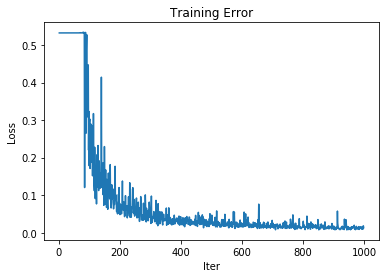

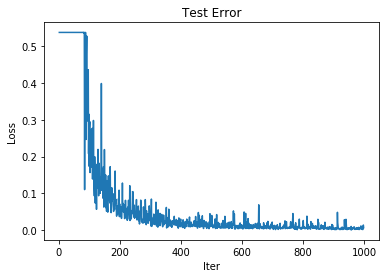

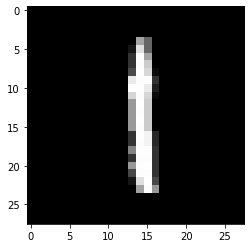

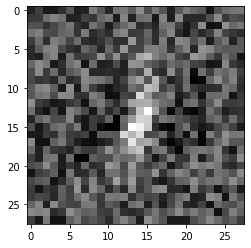

In [9]:
errs = []
errs_test = []

# train for 1000 epochs
for i in range(1,1000):
    # training error, w and b
    the_w, the_b, training_error = optimize(binary_x_train, binary_y_train, iters=i)
    errs.append(training_error)
    
    loss = 0
    test_e = 0
    # get the test error from the learned w and b
    for itm in np.arange(len(binary_x_test)):
        
        pred = predict(binary_x_test[itm],the_w,the_b)
        
        if pred != binary_y_test[itm]:
            loss+=1
            
        test_e = loss/len(binary_y_test)
        
    errs_test.append(test_e)

# Print errors    
print('Train error:', training_error) 
print('Test error:', test_e) 

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,1000), errs)
ax.set_xlabel('Iter')
ax.set_ylabel('Loss') 
plt.title('Training Error')
 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,1000), errs_test)
ax.set_xlabel('Iter')
ax.set_ylabel('Loss') 
plt.title('Test Error')

item = np.random.choice(np.arange(len(binary_y_test)))
pred = predict(binary_x_test[item,:], the_w, the_b)
print(binary_y_test[item])
print(pred)
fig = plt.figure()
img = binary_x_test[item,:].reshape(28,28)
imgplot = plt.imshow(img, cmap='gray')

print('==== The learned weights ==== ')

print(the_w.shape)
print(the_w)
fig = plt.figure()
img = the_w.reshape(28,28)
imgplot = plt.imshow(img, cmap='gray')

In [10]:
pairs = [(1,7),(3,9),(0,9),(3,8)]
train_err = [training_error]
test_err = [test_e]

# repeat the perceptron training for the 4 defined pairs
for p in pairs:
    
    cond = (y_train == p[0]) + (y_train == p[1])
    binary_x_train = x_train[cond,:]
    binary_y_train = y_train[cond]*1.

    cond = (y_test == p[0]) + (y_test == p[1])
    binary_x_test = x_test[cond,:]
    binary_y_test = y_test[cond]*1.

    binary_y_train[binary_y_train == p[0]] = -1
    binary_y_train[binary_y_train == p[1]] = 1

    binary_y_test[binary_y_test == p[0]] = -1
    binary_y_test[binary_y_test == p[1]] = 1  
    
    # get the train error for 1000 epochs
    the_w, the_b, training_error = optimize(binary_x_train, binary_y_train, iters=1000)
        
    train_err.append(training_error)
        
    loss = 0
    test_e = 0
    # get the test error from the learned w and b
    for itm in np.arange(len(binary_x_test)):
        
        pred = predict(binary_x_test[itm],the_w,the_b)
        
        if pred != binary_y_test[itm]:
            loss+=1
            
        test_e = loss/len(binary_y_test)
        
    test_err.append(test_e)

In [11]:
print(train_err)
print(test_err)

[0.013422818791946308, 0.03352041208579996, 0.05447019867549669, 0.023921832884097036, 0.09564346519779669]
[0.0070921985815602835, 0.04160887656033287, 0.04408122833085686, 0.012066365007541479, 0.09576612903225806]


### 3: Multi Layer Perceptron (10 points)

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [5]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
- You may use tf.layers.dense to implement a fully connected layer. 
- To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [6]:
class MLP:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self, config):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
        ######### Complete the function ######### 
        
            inputL = tf.layers.dense(inputs=self.im, units=784, activation=tf.nn.relu, name='inp_'+str(config[0]))  
        
            if(config[0] == 0):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=1000, activation=tf.nn.relu, name='h2_'+str(config[0])) 
                self.logits = tf.layers.dense(inputs=hidden2, units=10, name='lg_'+str(config[0]))                 
            
            if(config[0] == 1):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=1000, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=1000, activation=tf.nn.relu, name='h3_'+str(config[0]))                
                self.logits = tf.layers.dense(inputs=hidden3, units=10, name='lg_'+str(config[0]))   
                
            if(config[0] == 2):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))            
                self.logits = tf.layers.dense(inputs=hidden1, units=10, name='lg_'+str(config[0]))     
                
            if(config[0] == 3):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=2000, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=3000, activation=tf.nn.relu, name='h3_'+str(config[0]))  
                hidden4 = tf.layers.dense(inputs=hidden3, units=2000, activation=tf.nn.relu, name='h4_'+str(config[0]))                 
                hidden5 = tf.layers.dense(inputs=hidden4, units=1000, activation=tf.nn.relu, name='h5_'+str(config[0]))                 
                self.logits = tf.layers.dense(inputs=hidden5, units=10, name='lg_'+str(config[0]))                 
                
            if(config[0] == 4):

                hidden1 = tf.layers.dense(inputs=inputL, units=1000, activation=tf.nn.relu, name='h1_'+str(config[0]))
                hidden2 = tf.layers.dense(inputs=hidden1, units=512, activation=tf.nn.relu, name='h2_'+str(config[0]))  
                hidden3 = tf.layers.dense(inputs=hidden2, units=256, activation=tf.nn.relu, name='h3_'+str(config[0]))  
                hidden4 = tf.layers.dense(inputs=hidden3, units=128, activation=tf.nn.relu, name='h4_'+str(config[0]))                 
                hidden5 = tf.layers.dense(inputs=hidden4, units=64, activation=tf.nn.relu, name='h5_'+str(config[0]))                 
                self.logits = tf.layers.dense(inputs=hidden5, units=10, name='lg_'+str(config[0]))                    
            
            self.preds = tf.nn.softmax(self.logits)           

    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)
            
    def getComplexity(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
        self.compx = tf.constant(total_parameters)         

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [7]:
model = MLP(x_train, y_train, './MLP_logdir/', 0.001, 2, 10)
model.create_model([0])
model.compute_loss()
model.optimizer()
model.getComplexity()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [8]:
startT = time.time()
losses = []
acc = []
losses_test = []

# Model training
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    y_real = np.argmax(y_test, axis=1) 
    batch_size_test = 10
    nb_test_points = x_test.shape[0]  
    
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        # Train on batch
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        # Record training loss and accuracy
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        losses.append(loss)
        acc.append(acc_train)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)

        # Record testing loss
        preds_test, loss_test = sess.run([model.preds, model.loss],
                                 feed_dict={model.im: x_test, 
                                            model.labels: y_test})
        losses_test.append(loss_test)
        
    saver.save(sess, model.output_dir, global_step=epoch)      
    
# sess.close()
timeTaken = int(time.time() - startT)

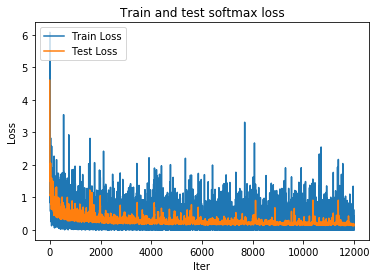

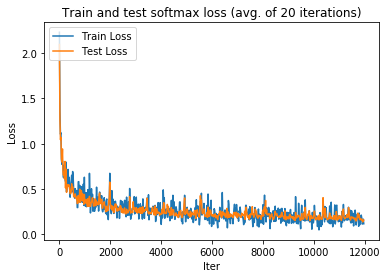

In [29]:
# Plot
train_norm = []
test_norm = []

# Create avg of 20 iters arrays
v = 0
for i in range(len(losses)):
    v += losses[i]
    if (i % 20 == 0) and (i != 0):
        train_norm.append(v/20)
        v = 0

v = 0
for j in range(len(losses_test)):
    v += losses_test[j]
    if (j % 20 == 0) and (j != 0):
        test_norm.append(v/20)
        v = 0
    
train_norm = np.array(train_norm)
test_norm = np.array(test_norm)

major_ticks = np.arange(0, test_norm.shape[0], 20)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(losses, label="Train Loss")
plt.plot(losses_test, label = 'Test Loss')
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.legend(loc="upper left")
plt.title('Train and test softmax loss')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(train_norm, label="Train Loss")
plt.plot(test_norm, label = 'Test Loss')
plt.ylabel('Loss')
plt.xlabel('Iter')
plt.legend(loc="upper left")
plt.title('Train and test softmax loss (avg. of 20 iterations)')
ax.set_xticklabels([0,0,2000,4000,6000,8000,10000,12000])
plt.show()

During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [17]:
perfs = []
perfs_train = []
complexities = []
duration = [timeTaken]

batch_size_test = 20
nb_test_points = x_train.shape[0] 
nb_iterations = nb_test_points//batch_size_test

preds = []
for i in range(nb_iterations):
    input_x_test = x_train[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds,
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_train[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))

all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_train, axis=1)
acc_train = np.mean((all_preds==y_real)*1)
perfs_train.append(acc_train)
print('Train accuracy achieved: %.3f' %acc_train)

nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds,
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
        
complexity = sess.run(model.compx)
complexities.append(complexity)

all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
perfs.append(acc_test)
print('Test accuracy achieved: %.3f' %acc_test)

Train accuracy achieved: 0.940
Test accuracy achieved: 0.935



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [11]:
sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


In [12]:
for nets in range(1,5):
    
    model = MLP(x_train, y_train, './MLP_logdir_'+(str(nets))+'/', 0.001, 2, 10)
    model.create_model([nets])
    model.compute_loss()
    model.optimizer()
    model.getComplexity()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
        
    startT = time.time()    
    for epoch in range(model.nb_epochs):
        #print('Epoch: ',epoch)
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            #print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)
        
    timeTaken = int(time.time() - startT)
    duration.append(timeTaken) 
    
    batch_size_test = 20
    nb_test_points = x_train.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_train[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_train[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))          
            
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_train, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    perfs_train.append(acc_test)       
    
    preds = []
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test    
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
            
    complexity = sess.run(model.compx)
    complexities.append(complexity)            
            
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    perfs.append(acc_test)        
        
    sess.close()


In [83]:
c_sum = 0
compxs = np.zeros(len(complexities))
for c in range(len(complexities)):
    if c > 0:
        compxs[c] = complexities[c] - complexities[c-1] 
        c_sum += complexities[c]        
    else:
        compxs[c] = complexities[c]

print('Train Acc: ',perfs_train)        
print('Test Acc: ',perfs)
#print(complexities)
# Complexities are comulative nets complexity values, so the function above extracts the actual values for each net
print('Params: ', compxs)
print('Time: ', duration)

Train Acc:  [0.9459166666666666, 0.9467666666666666, 0.9684833333333334, 0.9436333333333333, 0.95875]
Test Acc:  [0.9624, 0.9438, 0.9624, 0.9424, 0.9571]
Params:  [ 2411450.  3412450.  1410450. 17418450.  2086082.]
Time:  [104, 132, 59, 741, 84]


5


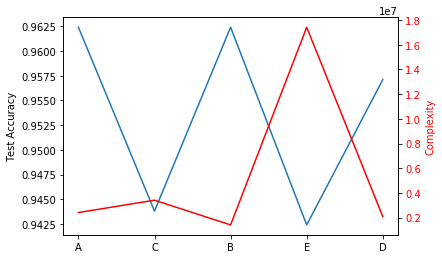

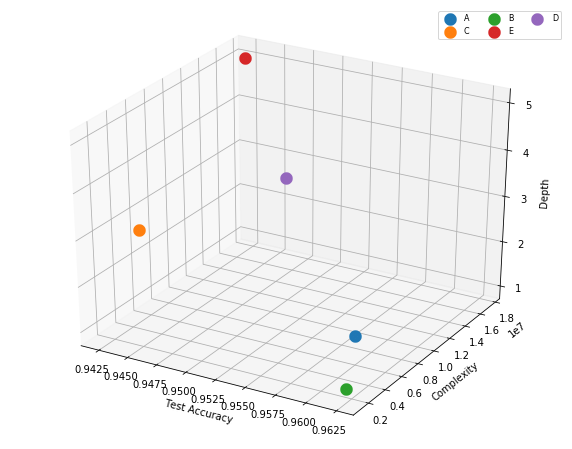

In [82]:
# Accuracy vs Complexity vs Depth charts
x = ['A','C','B','E','D']
y1 = perfs
y2 = compxs
y3 = [2,3,1,5,5]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(x, y1)
ax1.set_ylabel('Test Accuracy')

ax2 = ax1.twinx()
ax2.plot(x, y2, 'r-')
ax2.set_ylabel('Complexity', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
def f(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

z = []
for i in range(len(y1)):  
    z.append(f(y1[i], y2[i]))    
    
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

a = ax.scatter(y1[0], y2[0], y3[0], cmap='viridis', linewidth=8)
c = ax.scatter(y1[1], y2[1], y3[1], cmap='viridis', linewidth=8)
b = ax.scatter(y1[2], y2[2], y3[2], cmap='viridis', linewidth=8)
e = ax.scatter(y1[3], y2[3], y3[3], cmap='viridis', linewidth=8)
d = ax.scatter(y1[4], y2[4], y3[4], cmap='viridis', linewidth=8)
print(y3[4])
ax.set_xlabel('Test Accuracy')
ax.set_ylabel('Complexity')
ax.set_zlabel('Depth');
ax.set_zticks([1,2,3,4,5])
plt.legend((a,c,b,e,d),
           x,
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)


### 4. Convolutional Neural Network (10 points)
Now that we are more familiar with the MLP algorithm, it is time to see how it compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

##### Task 4.1
Complete the function 'create_model' of the class CNN above. Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 

   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
+ You may use tf.layers.conv2d to implement a convolutional layer. 
+ To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [6]:
class CNN:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self, config):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            ######### Complete the function #########
            
            inputL = tf.layers.conv2d(inputs=self.im, filters=32, strides=1, kernel_size=[4,4], activation=tf.nn.relu, name='h1_'+str(config[0]))
            
            if(config[0] == 0):
                        
                conv1 = tf.layers.conv2d(inputs=inputL, filters=64, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h2_'+str(config[0]))
                conv2 = tf.layers.conv2d(inputs=conv1, filters=128, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h3_'+str(config[0]))
                flatten = tf.layers.flatten(conv2, name='h4_'+str(config[0]))
                
            if(config[0] == 1):
                        
                conv1 = tf.layers.conv2d(inputs=inputL, filters=64, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h2_'+str(config[0]))
                conv2 = tf.layers.conv2d(inputs=conv1, filters=32, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h3_'+str(config[0]))
                conv3 = tf.layers.conv2d(inputs=conv2, filters=16, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h4_'+str(config[0]))
                flatten = tf.layers.flatten(conv3, name='h5_'+str(config[0])) 
                
            if(config[0] == 2):
                        
                conv1 = tf.layers.conv2d(inputs=inputL, filters=64, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h2_'+str(config[0]))
                conv2 = tf.layers.conv2d(inputs=conv1, filters=128, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h3_'+str(config[0]))
                conv3 = tf.layers.conv2d(inputs=conv2, filters=256, strides=2, kernel_size=[4,4], activation=tf.nn.relu, name='h4_'+str(config[0]))
                flatten = tf.layers.flatten(conv3, name='h5_'+str(config[0]))
                
            if(config[0] == 3):
                        
                conv1 = tf.layers.conv2d(inputs=inputL, filters=64, strides=1, kernel_size=[2,2], activation=tf.nn.relu, name='h2_'+str(config[0]))
                conv2 = tf.layers.conv2d(inputs=conv1, filters=128, strides=1, kernel_size=[2,2], activation=tf.nn.relu, name='h3_'+str(config[0]))
                flatten = tf.layers.flatten(conv2, name='h4_'+str(config[0]))                
                
            if(config[0] == 4):
                        
                flatten = tf.layers.flatten(inputL, name='h2_'+str(config[0]))                       
                
                
            self.logits = tf.layers.dense(inputs=flatten, units=10, name='h99_'+str(config[0])) 
            self.preds = tf.nn.softmax(self.logits)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.losses.softmax_cross_entropy(self.labels, self.logits)
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)
            
    def getComplexity(self):
        total_parameters = 0
        for variable in tf.trainable_variables():
            # shape is an array of tf.Dimension
            shape = variable.get_shape()
            variable_parameters = 1
            for dim in shape:
                variable_parameters *= dim.value
            total_parameters += variable_parameters
        self.compx = tf.constant(total_parameters)             

CNNs leverage dependencies between neighbouring pixels, however this information is partially lost when we vectorized our data. For training CNNs we will need to recover our initial shape of $N \times 28 \times 28$.

In [7]:
edge = int(np.sqrt(nb_features))
x_train.resize([n_train, edge, edge])
x_test.resize([n_test, edge, edge])

We instantiate our CNN class, start the corresponging tensorflow session and initiate the trainable variables. 

In [8]:
model = CNN(x_train, y_train, './CNN_logdir/', 0.001, 2, 10)
model.create_model([0])
model.compute_loss()
model.optimizer()
model.getComplexity()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We start training:

In [9]:
startT = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        #print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
# sess.close()
timeTaken = int(time.time() - startT)

we loop over the test dataset and compute the corresponding classification accuracy. 

- Similar to Task 3.1, include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report. 

In [10]:
perfs = []
complexities = []
duration = [timeTaken]

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))

complexity = sess.run(model.compx)
complexities.append(complexity)

all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
acc_test = np.mean((all_preds==y_real)*1)
perfs.append(acc_test)
print('Test accuracy achieved: %.3f' %acc_test)

Test accuracy achieved: 0.990


##### Task 4.2
Similar to task 3.2, discuss 
- Plot a graph showing complexity (number of paramters) vs. accuracy vs. depth of networks. For this part you need to train four additional CNNs of different depths/widths (again, your choice) and report the results in a Table. Discuss the results and provide conclusion.


- In addition discuss and analyze the differences in term of performance, number of model parameters (i.e. weights/biases) and training/testing times between CNNs and MLPs. Provide a concusion. (For these discussions you should compare your results in Table 4.2 to Table 3.2)

In [11]:
sess.close()

for nets in range(1,5):
    
    model = CNN(x_train, y_train, './CNN_logdir_'+(str(nets))+'/', 0.001, 2, 10)
    model.create_model([nets])
    model.compute_loss()
    model.optimizer()
    model.getComplexity()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
        
    startT = time.time()    
    for epoch in range(model.nb_epochs):
        #print('Epoch: ',epoch)
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            #print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)
        
    timeTaken = int(time.time() - startT)
    duration.append(timeTaken) 
    
    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        input_x_test = input_x_test[:, :, :,np.newaxis]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))

    complexity = sess.run(model.compx)
    complexities.append(complexity)    
            
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    perfs.append(acc_test)        
        
    sess.close()

In [13]:
compxs = np.zeros(len(complexities))
for c in range(len(complexities)):
    if c > 0:
        compxs[c] = complexities[c] - complexities[c-1] 
        c_sum += complexities[c]        
    else:
        compxs[c] = complexities[c]
        
print(perfs)
print(complexities)
print(compxs)
print(duration)

[0.9895, 0.9825, 0.9878, 0.9814, 0.9832]
[185066, 259620, 951310, 1670136, 1870690]
[185066.  74554. 691690. 718826. 200554.]
[97, 96, 204, 229, 34]


### 5. Visualizing learned filters and activations (6 points)
It is sometimes useful to visualize what kind of filters a CNN have learned. One way to do so is to plot each filter of size [kernel_size $\times$ kerne_size]. 

- Once your CNN (in Question 6) is trained, access its filters via 'tf.get_collection' and plot them on a grid for each layer. What patterns do you observe, why?
- In addition, plot the activations of each layer for two images chosen from digit-classes '2' and '9'. Discuss your observations

Hint: 
+ Activations are for example the outputs of tf.layers.conv2D.
+ Use tf.get_collection to access the learned filters of each layers. For this, you need to know how they are named (which can be accessed by tf.trainable_variables among other means of doing so).

The plotted feature maps and learned filters should be plotted in the same way as in the images bellow. (left: Feature Maps, right: learned Filters)

![Examples of activation maps (left), and learned features (right))](im.png)

In [24]:
sess.close()

### 6. Multi Task Learning (12 points)

This question concerns the practice of multi-task learning (MTL). 
The aim of multi task learning is to leverage two (or more) related tasks in the learning process with the hope that leanring one task aids perfromance in learning the other task(s) and thus improves predicitve power for at least one (ideally all) of the tasks. 

There are two distinct flavours of MTL: Hard parameter  sharing and soft parameter sharing. We will be focusing on the former in this question.
Hard paramter sharing occurs when two tasks share a common network which then splits into task specific paths (e.g. a series of convolutional layers with two paths of dense layers for two seperate tasks). 

In this question, you will explore the FASHION MNIST dataset and be coding up your own MTL model and considering the pros and cons of MTL compared to single task learning. 

We have written the code to pre-load this dataset and split it into two related tasks for you:

- Task 1 - Clothing item 10 class classification (e.g. shoes, t-shirts etc) across 10 goups - $ y \in \mathbb{R^{10}} $
- Task 2 - Clothing group three class classification - predicitng whether a viewed clothing image belongs to one of three groups - $ y \in \mathbb{R^{3}} $
    - These groups are shoes (Sandal, Sneaker and Ankle Boot),  Gendered (Dress, Shirt and Bag) and Uni-Sex (T-shirt, Trouser, Pullover and Coat). 


#### Note : Alternativley use the tf.nn module. 

#### Note  : We advise the use of only a single epoch for this question for the sake of computation time.  However, if you want to utilise additional epochs feel free to do so just be aware of the longer training time and be consistent over all networks. 

In [25]:
"""
Code for loading the dataset
"""
import keras.datasets.fashion_mnist as fashion_mnist
from keras.utils import to_categorical

def load_data(): 
    # train_X: (60000, 28, 28)
    # train_y: (60000,)
    # test_X: (10000, 28, 28)
    # test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    # map to new label
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    # train_X: (60000, 28, 28, 1)
    # test_X: (10000, 28, 28, 1)
    # train_y: (60000, n_class = 10)
    # test_y: (10000, n_class = 3)
    train_X = np.expand_dims(train_X, axis=3)
    test_X = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1 = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2 = to_categorical(test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2


x_train, y_train_1, y_train_2, x_test, y_test_1, y_test_2 = load_data()

Using TensorFlow backend.


#### Task 6.1

In this question you will construct two seperate networks of identical structure (excpet the logits and pred layers) one for each of the two tasks.

In other words, create a network for item classification and a network for item group classification. 


Complete the Task_1_NN and Task_2_NN below. These single task networks will form the basis of your work in this question. 

For the sake of convieience, we will use the same CNN filters as Question 4 - $[32, 64, 128]$. However our kernel size will be 3 $\times$ 3 and a stride of 1 for all convolutional layers. Maxpooling layers will also need to be implemented after the first and second convolutional layers. These maxpooling layers have a kernel size of two and a stride of 2. 

After the final convolution, flatten the outputs and pass them to dense layers $[3136, 1024, 100 , N]$ where $N$ is the number of outputs required (10 or 3). 

As with Question 4, the function 'create_model' to be cpomplemted defines the class variables:
 - Task 1
     - self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected (i.e. dense) layer</font>.__ 
     - self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.
 - Task 2
      - self.logits $\in \mathbb{R^{3}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 
      - self.preds $\in \mathbb{R^{3}}$ containing posterior probabilities.
      
The method definitons remain the same  as in previous questions. 
      
      
#### Note: We advise you save the number of parameters and accuracy of the models in order to save time later. 

In [27]:
class Task_1_NN():
    def __init__(self, x_train, y_train_1,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
    
     def create_model(self):            
        with tf.variable_scope("Task_1", reuse=tf.AUTO_REUSE):
            
            ######### Complete the function ######### 
            self.logits = 
            self.preds =
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = 
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_1) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_1, var_list=self.model_vars)
            


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

In [ ]:
class Task_2_NN():
    def __init__(self, x_train, y_train_2,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_2 = y_train_2
        self.m = x_train.shape[0]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")
    
     def create_model(self):            
        with tf.variable_scope("Task_2", reuse=tf.AUTO_REUSE):
            
            ######### Complete the function ######### 
            self.logits = 
            self.preds =
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_2 = 
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_2) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_2, var_list=self.model_vars)

#### Now train and test Task 1:

In [ ]:

model_1 = Task_1_NN(x_train, y_train_1, './Task1_logdir/', 0.001, 2, 10)            
model_1.create_model()     

model_1.compute_loss()
model_1.optimizer()   

model_1.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_1.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_1.output_dir):
    os.makedirs(model_1.output_dir)  

"""
Train
"""

for epoch in range(model_1.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model_1.x_train[randomize,:]
    y_in_1 = model_1.y_train_1[randomize,:]
    for i in range(model_1.nb_iterations):
        input_x_train = x_in[i*model_1.batch_size: (i+1)*model_1.batch_size]
        input_y_train_1 = y_in_1[i*model_1.batch_size: (i+1)*model_1.batch_size]
        _ , preds_1, loss_1, loss_summ = sess.run([model_1.trainer, model_1.pred_1,  model_1.loss_task_1, model_1.loss_summ], 
                                 feed_dict={model_1.X: input_x_train, 
                                            model_1.y_1: input_y_train_1})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f,  batch accuracy_1 %.3f' %(epoch, i, loss_1,acc_train_1))
        writer.add_summary(loss_summ, epoch * model_1.nb_iterations + i)
    saver.save(sess, model_1.output_dir, global_step=epoch) 
end = time.time()

In [ ]:
"""
Test
"""


batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1 = sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_1= sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
print(all_preds_1)
print(y_real_1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)

In [ ]:
sess.close()

#### Now train and test Task 2

In [ ]:
model_2 = Task_2_NN(x_train, y_train_2, './Task2_logdir/', 0.001, 2, 10)            
model_2.create_model()     

model_2.compute_loss()
model_2.optimizer()   

model_2.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_2.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

"""
Train
"""
for epoch in range(model_2.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model_2.x_train[randomize,:]
    y_in_2 = model_2.y_train_2[randomize,:]
    for i in range(model_2.nb_iterations):
        input_x_train = x_in[i*model_2.batch_size: (i+1)*model_2.batch_size]
        input_y_train_2 = y_in_2[i*model_2.batch_size: (i+1)*model_2.batch_size]
        _ , preds_2, loss_2, loss_sum = sess.run([model_2.trainer, model_2.pred_2,  model_2.loss_task_2, model_2.loss_sum], 
                                 feed_dict={model_2.X: input_x_train, 
                                            model_2.y_2: input_y_train_2})
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_2 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_2,acc_train_2))
        writer.add_summary(loss_sum, epoch * model_2.nb_iterations + i)
    saver.save(sess, model_2.output_dir, global_step=epoch) 

In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test.shape[0]
nb_iterations = nb_test_points//batch_size_test
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_2 = sess.run(model_2.pred_2, 
                             feed_dict={model_2.X: input_x_test})
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_2= sess.run([model_2.pred_2], 
                             feed_dict={model_2.X: input_x_test})
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)

print('Test accuracy - task 2 achieved: %.3f' %acc_test_2) 


In [ ]:
sess.close()

#### Task 6.2 - Building a MTL Network

In this question, we wish for you to complete the MTL class below and use it to train and test a MTL model on the two MNIST fashion tasks. 

Similar to Questions 3 and 4, our MTL class is initiliased via
 - x_train, the training matrix
 - y_train_1, the fashion labels for task 1 (Fashion Item  classification)
 - y_train_2, the labels for task 2 (Fashion Group classification)
 - $\lambda \in [0,1]$ , lambda_, the loss weight for task 1 (1- $\lambda$) is the loss weight for task 2
 - output_dir, the directory where model parameters and tensorbaord event files will be stored. 
 - lr, the learning rate of the ADAM optimiser 
 - nb_epochs, the number of epochs to use
 - batch_size, the number of data points in each mini-batch

Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions.  The output of the shared dense layer is passed to two series of task specific dense layers, one for each of the two tasks. 

The architecture is as follows:
 - Shared Convolutional layers $[32, 64, 128]$ with max pooling after the first and second conv layers
     - kernel size ($ 3 \times 3$) for conv and ($2 \times 2$) for max pool
     - stride 1 for conv and 2 for max pooling
 - Flatten 
 - Shared Dense Layer $[3136]$ - the outputs of which are passed to the two task dense layers
 - Task 1 Dense Layers $[1024, 100, 10]$ - 10 is the dimenson of the logits/preds
 - Task 2 Dense Layers $[1024, 100, 3]$ - 3 is the dimenson of the logits/preds 
 - Task 1 Activation Layer - as earlier we use softmax
 - Task 2 Activation Layer  - as earlier we use softmax

This architecture is illustrated in the figure below minus the flattening layer.


<img src="mtl_2.jpg" alt="The MTL network" title="MTL Architecture" />

 
 The function 'create_model' defines the class variables:
  - self.logits_1 $\in \mathbb{R^{10}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 1 task layers. 
  - self.logits_2 $\in \mathbb{R^{3}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 2 task layers
  - self.preds_1 $\in \mathbb{R^{10}}$ containing posterior probabilities for the first task.
  - self.preds_2 $\in \mathbb{R^{3}}$ containing posterior probabilities for the second task.
  
As above, use self.logits to complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss albeit for each task. 

The total loss which is a sum of the weighted losses from tasks 1 and 2 ($\lambda * L_1 + (1-\lambda) * L_2$) is passed to the optimiser. 

#### For this question set $\lambda$ to be 0.5 for equal weighting. 

 #### Note: Do not worry about the optimiser - we still only need one optimiser for joint training of the MTL network 
      - The tasks can be trained alternately but this has its drawbacks

In [ ]:
class MTL:
    def __init__(self, x_train, y_train_1, y_train_2, lambda_, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.y_train_2 = y_train_2
        self.lambda_ = lambda_
        
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")

    
    def create_model(self):            
        with tf.variable_scope("MTL", reuse=tf.AUTO_REUSE):
            
            ### Complete the function #####
            
            self.logits_1 = 
            self.pred_1 = 
            
            self.logits_2 = 
            self.pred_2 = 
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 =

            self.loss_task_2 = 

            self.loss_total = self.lambda_*self.loss_task_1 + (1-self.lambda_)*self.loss_task_2 
            #########################################
            self.loss_task_1_graph = tf.summary.scalar("softmax_loss_task_1", self.loss_task_1) 
            self.loss_task_2_graph = tf.summary.scalar("softmax_loss_task_2", self.loss_task_2)             
            self.loss_sum = tf.summary.scalar("softmax_loss", self.loss_total) 
            
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_total, var_list=self.model_vars)

In [ ]:
"""
Create model and initialise it and tensorflow session
"""


model = MTL(x_train, y_train_1, y_train_2, 0.5, './MTL_logdir/', 0.001, 2, 10)             #       
model.create_model()     

model.compute_loss()
model.optimizer()   

model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 

##### Now train and test your MTL model

In [ ]:
"""
Train
"""



for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in_1 = model.y_train_1[randomize,:]
    y_in_2 = model.y_train_2[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_1 = y_in_1[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_2 = y_in_2[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds_1, preds_2, loss_1, loss_2, loss_summ= sess.run([model.trainer, model.pred_1, model.pred_2, model.loss_task_1, model.loss_task_2, model.loss_sum], 
                                 feed_dict={model.X: input_x_train, 
                                            model.y_1: input_y_train_1,
                                            model.y_2: input_y_train_2})

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        print('Epoch %d, Iteration %d, loss_1 %.3f, loss_2 %.3f, batch accuracy_1 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_1, loss_2, acc_train_1, acc_train_2))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()



In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)
print('Test accuracy - task 2 achieved: %.3f' %acc_test_2)

In [ ]:
sess.close()

#### Discuss the performance of the MTL network compared to the single task networks. What do think are the most important things to consider when using MTL?

##### Task 6.3

In this task we want you to compare the MTL's results for different values of $\lambda$. We want you to coampre $5$ different values of $\lambda$ with the stipulation that two of them must be $0$ and $1$; the other 3 are up to you. All other hyperparameters (e.g. number of dense shared layers) can be left as they were in Task 6.2. 

Plot a graph showing the Task 1 and Task 2 accuracies against values of $\lambda$. 
Comment on your results. 
Whats so special about the cases of $\lambda = 0$ and $\lambda = 1$?

####  Task 6.4

##### Similar to tasks  3.2 and 4.2

 - Plot a graph showing complexity (number of paramters) vs. accuracy for each of the to tasks in the MTL network. As above you will need to train four other additional MTL networks where you vary the number/size of the shared and  task specific layers (we advise not making the layers too large or too numerous to avoid very long training times). 
 - You should also include plots of the number of parameters vs accuracy for the individual task 1 and 2 networks - use different colours to distinguish these single task networks.
     - Note 1 : There is no need to train additional Task 1 and Task 2 networks simply use the formats from Question 6.1
     - Note 2: For all MTL formats set $\lambda$ to $0.5$ for equal weighting
     - Note 3: Due to the sub task structure, we will ignore depth in this evaluation as the two tasks can have different depth levels in the MTL architecture. 
     - Note 4: It is advised to include pooling layers (we leave the type of pooling up to you but recommned maxpooling) for the sake of training time - alternativly use larger strides. 
 
 - Discuss the effect of the number/size of the shared and task specific layers in terms of performance and training/testing times. Also compare the performance to the task specific networks from 6.1. 
 
 - Discuss the main pros and cons for multi-task learning.

### 7. Denoising Auto-Encoder (10 points)

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output. We will be using the MNIST dataset here.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

Complete the method compute_loss. Note that we don't have a classification problem anymore but a regression problem consisting of reconstructing the noiseless version of the input.

In [ ]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28,1])
        self.im_n = self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=1) #inject noise
        self.x_train = x_train
        
    def create_model(self):
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            self.recon_im = 
            #########################################
            
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss
            #########################################
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [ ]:
model = DAE(x_train, './DAE_logdir/', 0.001, 2, 10)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

- Test the robustness of the trained network to different levels of noise, demonstrate the results (figure or Table) and discuss them in your report. 
- Why this architecture is able to remove noise from data? 

### Task 8 - Building a Variational AutoEncoder (VAE) 12 Points

<br>

#### Why use a VAE?

<br>

<p style='text-align: justify;'>
Building on the standard AutoEncoder which was a way of learning some lower dimensional manifold the data could lie on, we want to impose a form of regularisation, that is, we want some topology structure. We want inputs to the AutoEncoder that have a certain structure to be mapped to similar areas in this lower dimensional latent space. But the standard AutoEncoder merely learns how to essentially compress data. In this task, we are interested in learning a more structured latent space where we can sample in this space to then generate a new image that theoretically belongs to the same dataset.
    
In this exercise, we will assume the structure in the latent space follows a standard bi-variate Gaussian i.e. mean $\begin{bmatrix}0\\0\end{bmatrix}$ and covariance $\begin{bmatrix}1&0\\0&1\end{bmatrix}$. This assumption is for simplicity but we can infact assume other distributions (outside the scope for this exercise). We will be using the MNIST dataset for this task.
    
</p>

<br>

#### Architecture

<img src="vae-diagram.png" alt="The Variational AutoEncoder" title="VAE Architecture" />

<br>

#### Notation

<br>

Before diving into some maths, lets define a few terms:
1. $\mathbf{X}$: the dataset distribution we wish to generate from
2. $\mathbf{z}$: the compressed latent variable which quantifies a set of attributes of our dataset
3. $\boldsymbol{\theta}$ : the parameters for the ***encoder*** network
4. $\boldsymbol{\phi}$: the parameters for the ***decoder*** network
5. $p(\mathbf{z})$: the probability of the compressed latent space (given it should follow a standard normal)
6. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{X})$: the conditional probability distribution of sampling the compressed latent variable given the dataset approximated by our encoder network with parameters $\boldsymbol{\phi}$
7. $p_{\boldsymbol{\theta}}(\mathbf{X}|\mathbf{z})$: the conditional probability distribution of generating the dataset given the compressed latent space by our decoder network with parameters $\boldsymbol{\theta}$

<br>

#### Optimisation

<br>

The quantity we are interested in maximising for the $i$-th observation is:

$
\begin{align}
    \log p (\mathbf{x}_i) && \text{which can be rewritten as...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p (\mathbf{x}_i) \text{d}\mathbf{z} & \text{as the integral over a distribution is 1...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)[\log p (\mathbf{z}|\mathbf{x}_i) - \log p(\mathbf{z}) + \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})]\text{d}\mathbf{z} & \text{consider Baye's rule...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log \frac{p (\mathbf{z}|\mathbf{x}_i)}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} - q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)\log \frac{p (\mathbf{z})}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} + q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})\text{d}\mathbf{z}\\
    &= \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) - \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]\\
    &=  \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) + \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) &\text{where the last two terms have been grouped as $\mathcal{L}$}
\end{align}
$

<br>


As the first term in the line above is intractable to compute, we can say that $\log p_\boldsymbol{\theta} (\mathbf{x}_i) \ge \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ as the KL-divergence is a distance measure (and hence non-negative) and $\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ is known as the **variational lower bound**. Instead of maximising the log probability directly, we can instead maximise this lower bound! If you are unfamiliar with the KL-divergence, check out this [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

<br>

The lower bound can be clearly seen as two main components:

$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) = \color{blue}{\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]} - \color{green}{\text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}))}
\end{align}
$
+ <font color='blue'> How well can we reconstruct our original data from the latent space?</font>
+ <font color='green'> How similar is the latent space to a standard Gaussian?</font>

A remark on the second point - we are trying to find a Gaussian distribution manifold in latent space for our dataset. This is known as a *variational* method which should be part of the Bayesian Machine Learning module.

<br>

#### Derivations

Given that $\mathbf{\hat{x}}_i$ is a draw from $p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})\sim\mathcal{N}(\mathbf{x},\sigma^2\mathbf{I})$, the expectation of $\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})$ can be computed as:

$
\begin{align}
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})] &= -\frac{m}{2}\log 2\pi\sigma^2 - \frac{1}{2}(\mathbf{\hat{x}}_i - \mathbf{x}_i)^\text{T}(\sigma^2\mathbf{I})^{-1}(\mathbf{\hat{x}}_i - \mathbf{x}_i)\\
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{Z}|\mathbf{X})} [\log p_{\boldsymbol{\theta}} (\mathbf{X}|\mathbf{Z})] &\propto \sum_{i = 1}^{i = n}\sum_{j = 1}^{j = m} (\hat{x}_{ij} - x_{ij})^2 & \text{as everything else is just a constant}
\end{align}
$

<font color='red'>Given that $q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i) \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I})$, derive the KL-divergence term between this and $p_\boldsymbol{\theta} (\mathbf{z})$ i.e. $\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I}))$:</font>

$
\begin{align}
\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I})) &= \int_{\mathbf{z}\in\mathcal{Z}} ?\text{ d}\mathbf{z}
\end{align}
$

Further readings: There are many useful online tutorials that provide deep insight as how VAEs work or to implement them; for instace [tutorial1](https://arxiv.org/abs/1606.05908) [tutorial2](http://ruishu.io/2018/03/14/vae/). 

#### Defining the Data and Helper Functions

In [ ]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (you can try convolutional layers as an extension)
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield (arg[r[i * size : (i + 1) * size]] for arg in args)
        
def visualise(X, y, sep = 2):
     """ Visualise the mapped 2D manifold """
    # Feel free to modify this code for your visualisations...
    
    Z  = Zf(x_test)
    Xh = Xf(z_grid)
    
    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

#### Task 8.1 Implementation of VAE

<br>

The simpler implementation of the VAE is to build off the MLP i.e. no convolutional layers. The code below is designed for this but feel free to swap out this assumption for convolutions should you feel more confident. Feel free to add `tf.summary` definitions in a similar way to previous tasks for tensorboard visualisations.

 #### Note: If implementing task 8.1 in TF (as guided bellow) is not straightforward for you, use an easier option: [Keras](https://keras.io/examples/variational_autoencoder/) implementation of VAE. In these case, you will be marked down 4 points but you can immediately proceed to task 8.2. 

In [ ]:
# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 64
epochs   = 20
alpha    = 1e-3

# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = 
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    with tf.name_scope('Mean'):
        z_mean   = 

    with tf.name_scope('Variance'):
        z_var    = 
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = 
        z_sample = 
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')
    
# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = 
    
    with tf.name_scope('Final'):
        t_X_hat  = 

# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        loss_ae  = 
        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl  = 
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!
for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')

#### Visualisation Check

In [ ]:
visualise(x_test, y_test)

####  Task 8.2

<br>

 - Plot the learning curve for your VAE
 - Generate new handwritten digits from your model by sampling `Z` = $\mathbf{z}\in\mathbb{R}^{n,2}$ and running `sess.run(t_X_hat, feed_dict = {z : Z))` in a separate code cell
     - Discuss how good / bad are these images?
         - Why are they good / bad? (consider the assumptions of your implementation of the VAE)
 - From observing your learnt manifold (by using the `visualise` function or otherwise), draw a comparison between the direct mapped points on your manifold (scatter plot) and the images that lay on the manifold (imshow)
     - Why are some points images more mixed than others?
     - Can we be smarter in where we should sample to get *better* generated handwritten digits?